In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from src.decisions.control_charts import *

plt.rcParams.update({'font.size': 16})

In [14]:
loc = 'nw2'
turbine = 'c02'

# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
models_folder = os.path.join(package_folder, 'models')
ss2_selected = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
ss2_selected['timestamp'] = pd.to_datetime(ss2_selected['timestamp'])
ss2_selected.set_index('timestamp', inplace=True)

SS1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS1_mode.parquet'))
SS2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_SS2_mode.parquet'))
FA1_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA1_mode.parquet'))
FA2_dbscan = pd.read_parquet(os.path.join(data_folder, 'interim',loc,'tracked_modes', 'dbscan_based', loc+turbine+'_FA2_mode.parquet'))

rfe_selected_data = pd.read_parquet(os.path.join(data_folder, 'interim', loc, 'rfe_selected_data', loc+turbine+'_rfe_selected_data.parquet'))

# SS1

In [15]:
all_predicitons = {}
all_smart_tracked = {}
all_modal_data = {}

In [16]:
mode = 'SS1'

X = rfe_selected_data.copy()
y = SS1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]
y = y.sort_index()

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= False) # , random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_moving_avg.loc[X_train.index].quantile(0.9)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].quantile(0.99)
prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

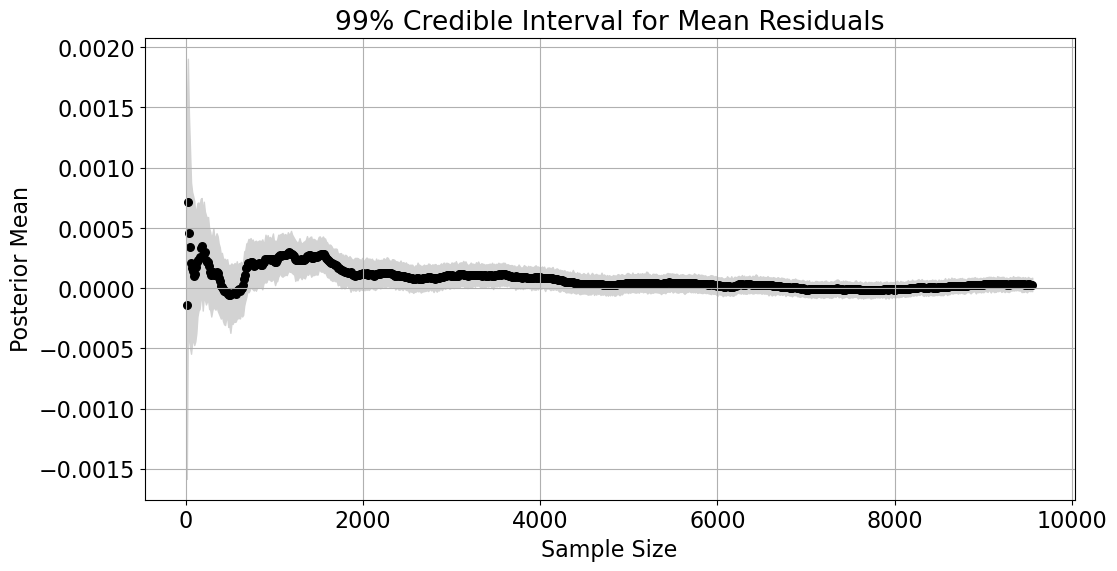

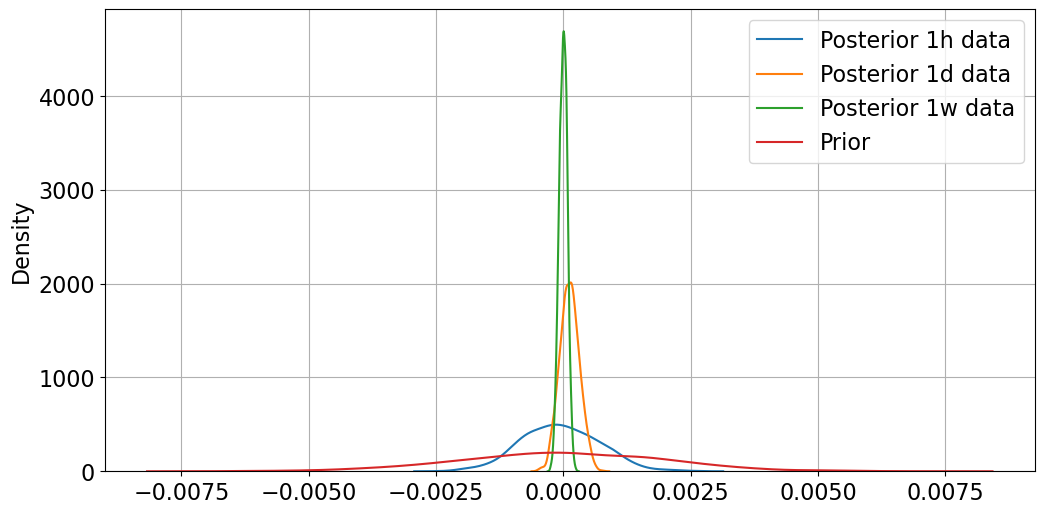

In [17]:
#Credible Interval
from src.decisions.bayseian_credible_interval import *
smart_tracked_training_indices = smart_tracked_modes.index.intersection(X_train.index)
prior_mean = predictions_df['residual'].loc[smart_tracked_training_indices].mean()
prior_std = predictions_df['residual'].loc[smart_tracked_training_indices].std()
prior_var = np.var(predictions_df['residual'].loc[smart_tracked_training_indices], ddof=1)
#prior_var = prior_std

smart_tracked_test_indices = smart_tracked_modes.index.intersection(X_test.index)

new_data = predictions_df['residual'].loc[smart_tracked_test_indices]

df = get_sequential_credible_intervals(new_data, prior_mean, prior_var, prior_var)
plot_sequential_credible_intervals(new_data, prior_mean, prior_var, prior_var, max_days=31)


start = X_test.index[1]
posterior_data_short = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(hours=1)]
posterior_data_middel = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=1)]
posterior_data_long = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=7)]

posterior_mean_short, posterior_var_short = calculate_posterior(posterior_data_short, prior_mean, prior_var, prior_var)
posterior_mean_middel, posterior_var_middle = calculate_posterior(posterior_data_middel, prior_mean, prior_var, prior_var)
posterior_mean_long, posterior_var_long = calculate_posterior(posterior_data_long, prior_mean, prior_var, prior_var)

plt.figure(figsize=(12, 6))
sns.kdeplot(np.random.normal(posterior_mean_short, np.sqrt(posterior_var_short), 1000), label='Posterior 1h data')
sns.kdeplot(np.random.normal(posterior_mean_middel, np.sqrt(posterior_var_middle), 1000), label='Posterior 1d data')
sns.kdeplot(np.random.normal(posterior_mean_long, np.sqrt(posterior_var_long), 1000), label='Posterior 1w data')
sns.kdeplot(np.random.normal(prior_mean, np.sqrt(prior_var), 1000), label='Prior')
plt.legend()
plt.grid()
plt.show()

# FA1

In [18]:
mode ='FA1'

X = rfe_selected_data.copy()
y = FA1_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]

#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y.copy()
for col in X.columns:
    Xy[col] = X[col]
X = Xy[X.columns]
y = y[y.columns]

# Split in training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.9)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()*3

smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

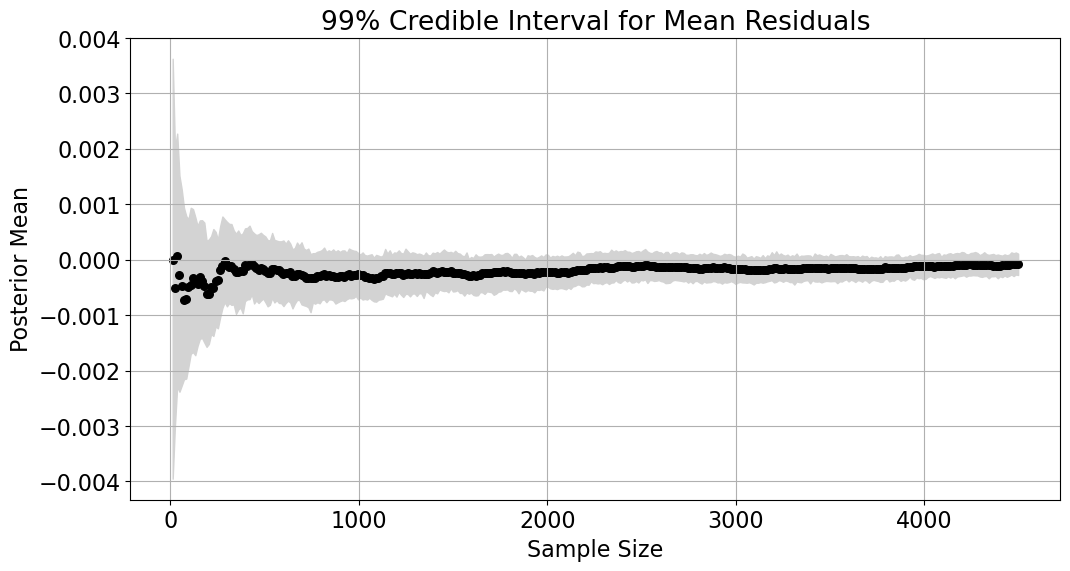

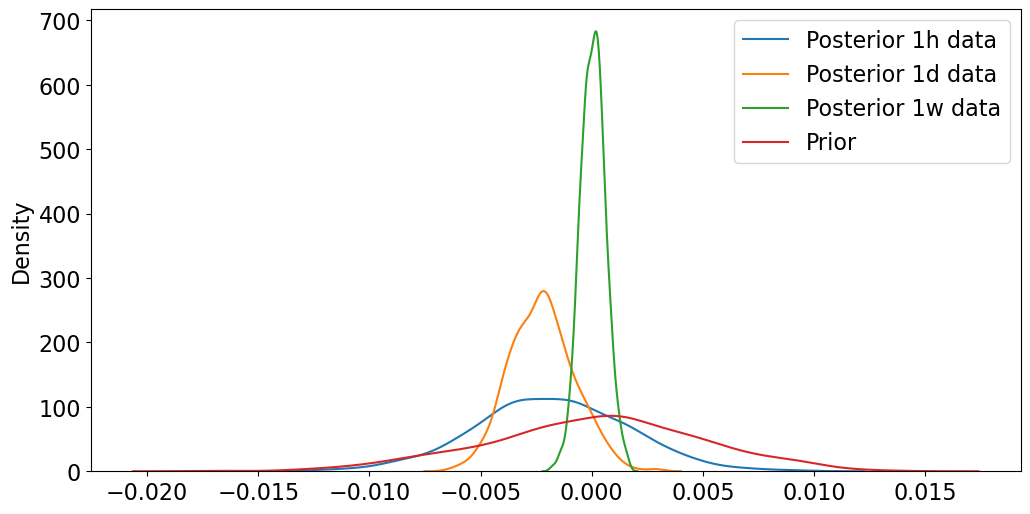

In [19]:
#Credible Interval
from src.decisions.bayseian_credible_interval import *
smart_tracked_training_indices = smart_tracked_modes.index.intersection(X_train.index)
prior_mean = predictions_df['residual'].loc[smart_tracked_training_indices].mean()
prior_std = predictions_df['residual'].loc[smart_tracked_training_indices].std()
prior_var = np.var(predictions_df['residual'].loc[smart_tracked_training_indices], ddof=1)
#prior_var = prior_std

smart_tracked_test_indices = smart_tracked_modes.index.intersection(X_test.index)

start = X_test.index[100]
stop = start + datetime.timedelta(hours=1)

new_data = predictions_df['residual'].loc[smart_tracked_test_indices]
new_data_mean = new_data.mean()
new_data_std = new_data.std()

plot_sequential_credible_intervals(new_data, prior_mean, prior_var, prior_var, max_days=31)


start = X_test.index[100]
posterior_data_short = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(hours=1)]
posterior_data_middel = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=1)]
posterior_data_long = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=7)]

posterior_mean_short, posterior_var_short = calculate_posterior(posterior_data_short, prior_mean, prior_var, prior_var)
posterior_mean_middel, posterior_var_middle = calculate_posterior(posterior_data_middel, prior_mean, prior_var, prior_var)
posterior_mean_long, posterior_var_long = calculate_posterior(posterior_data_long, prior_mean, prior_var, prior_var)

plt.figure(figsize=(12, 6))
sns.kdeplot(np.random.normal(posterior_mean_short, np.sqrt(posterior_var_short), 1000), label='Posterior 1h data')
sns.kdeplot(np.random.normal(posterior_mean_middel, np.sqrt(posterior_var_middle), 1000), label='Posterior 1d data')
sns.kdeplot(np.random.normal(posterior_mean_long, np.sqrt(posterior_var_long), 1000), label='Posterior 1w data')
sns.kdeplot(np.random.normal(prior_mean, np.sqrt(prior_var), 1000), label='Prior')
plt.legend()
plt.show()

# SS2

In [20]:
mode ='SS2'

X = rfe_selected_data.copy()
y_ = ss2_selected.copy()
y_ = y_.sort_values(by=['size'])
y_ = y_[~y_.index.duplicated(keep='first')][['mean_frequency']]

y = SS2_dbscan.copy()
y = y.sort_values(by=['size'])
y = y[~y.index.duplicated(keep='first')][['mean_frequency']]
#preprocess
from src.data.preprocessing import sin_cos_angle_inputs
X = sin_cos_angle_inputs(X)
Xy = y_.copy()
for col in X.columns:
    Xy[col] = X[col]
X_train = Xy[X.columns]
y_train = y_[y_.columns]

from catboost import CatBoostRegressor

regr_model = CatBoostRegressor(
    iterations=2000,
    depth=3,
    learning_rate=0.2,
    l2_leaf_reg=5,
    random_seed=0,
    posterior_sampling=True,
    loss_function='RMSEWithUncertainty',
    verbose=False)

#regr_model = CatBoostRegressor(posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
regr_model.fit(X_train, y_train)

# Full model predictions
predictions = regr_model.predict(X)
predictions_df = pd.DataFrame(predictions, columns=['prediction', 'spread'], index=X.index)
predicted_value = predictions[:,0]
predicted_total_uncertainty = predictions[:,1]

# Virtual ensemble predictions
virtual_ensemble_preds = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=200, ntree_end=500) #, virtual_ensembles_count=100, ntree_end=200)
virtual_ensemble_preds_df = pd.DataFrame(virtual_ensemble_preds, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

virtual_ensemble_preds_mean = virtual_ensemble_preds[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = virtual_ensemble_preds[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = virtual_ensemble_preds[:,2] # average estimated data uncertainty


# Predictions
from src.smart_tracking.smart_tracking import smart_tracking

uncertainty_ = pd.Series(knowledge_uncertainty, index=X.index).copy()
uncertainty_moving_avg = pd.Series(uncertainty_, index=X.index).rolling(6*6, center=True).mean()
uncertainty_lim = uncertainty_.loc[X_train.index].quantile(0.8)

prediction_lim = (y['mean_frequency'] - predictions_df['prediction']).loc[X_train.index].std()


smart_tracked_modes = smart_tracking(y['mean_frequency'], predictions_df['prediction'], uncertainty_, uncertainty_lim, prediction_lim)

predictions_df['virtual_ensemble_mean'] = virtual_ensemble_preds_mean
predictions_df['knowledge_uncertainty'] = knowledge_uncertainty
predictions_df['data_uncertainty'] = data_uncertainty
predictions_df['residual'] = y['mean_frequency'] - predictions_df['prediction']

all_smart_tracked[mode] = smart_tracked_modes
all_predicitons[mode] = predictions_df
all_modal_data[mode] = y

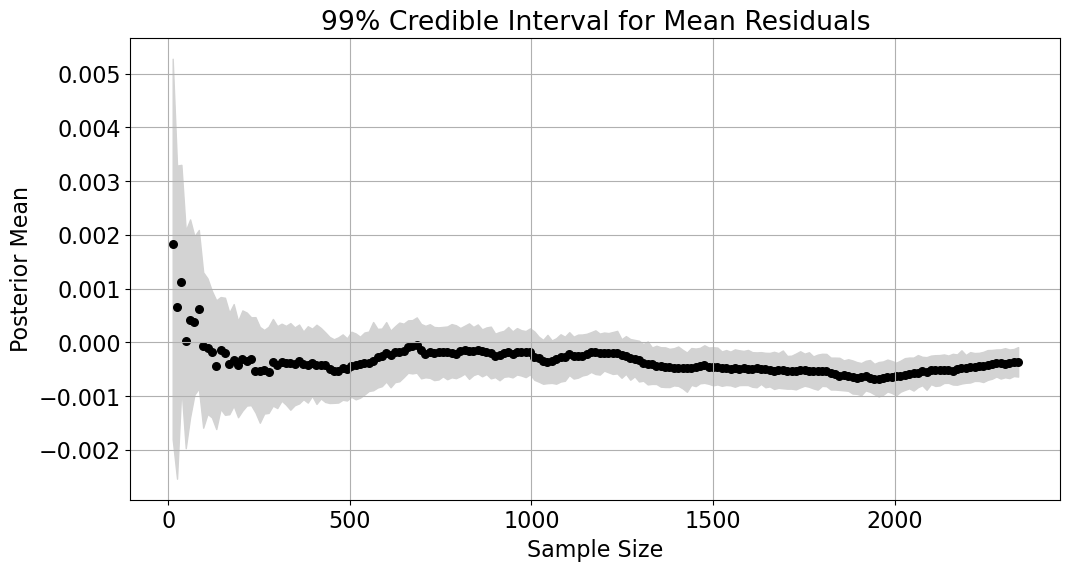

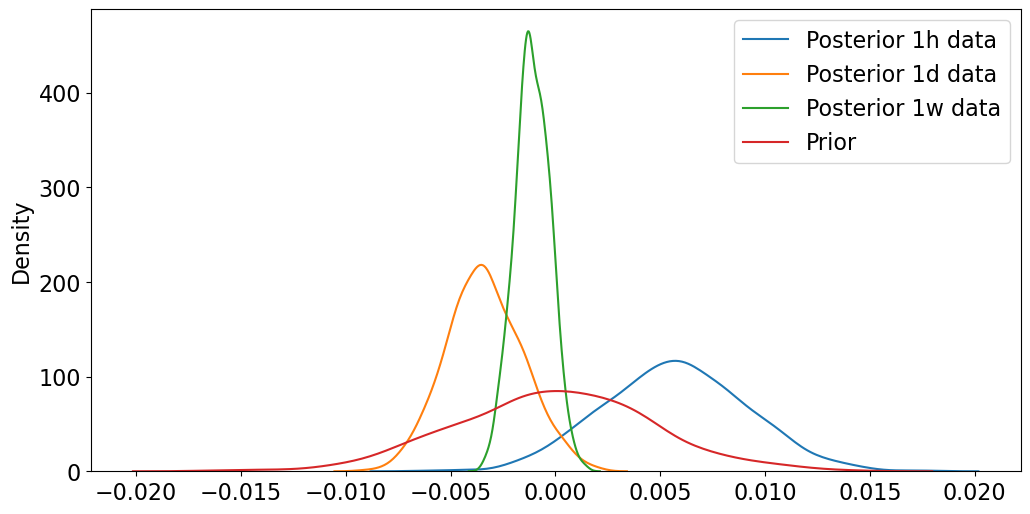

In [21]:
#Credible Interval
from src.decisions.bayseian_credible_interval import *
smart_tracked_training_indices = smart_tracked_modes.index.intersection(X_train.index)
prior_mean = predictions_df['residual'].loc[smart_tracked_training_indices].mean()
prior_std = predictions_df['residual'].loc[smart_tracked_training_indices].std()
prior_var = np.var(predictions_df['residual'].loc[smart_tracked_training_indices], ddof=1)
#prior_var = prior_std

smart_tracked_test_indices = smart_tracked_modes.index.intersection(X_test.index)

start = X_test.index[100]
stop = start + datetime.timedelta(hours=1)

new_data = predictions_df['residual'].loc[smart_tracked_test_indices]
new_data_mean = new_data.mean()
new_data_std = new_data.std()

df = get_sequential_credible_intervals(new_data, prior_mean, prior_var, prior_var)
plot_sequential_credible_intervals(new_data, prior_mean, prior_var, prior_var, max_days=16)


start = X_test.index[100]
posterior_data_short = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(hours=1)]
posterior_data_middel = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=1)]
posterior_data_long = predictions_df['residual'].loc[smart_tracked_test_indices].loc[start:start+datetime.timedelta(days=7)]

posterior_mean_short, posterior_var_short = calculate_posterior(posterior_data_short, prior_mean, prior_var, prior_var)
posterior_mean_middel, posterior_var_middle = calculate_posterior(posterior_data_middel, prior_mean, prior_var, prior_var)
posterior_mean_long, posterior_var_long = calculate_posterior(posterior_data_long, prior_mean, prior_var, prior_var)

plt.figure(figsize=(12, 6))
sns.kdeplot(np.random.normal(posterior_mean_short, np.sqrt(posterior_var_short), 1000), label='Posterior 1h data')
sns.kdeplot(np.random.normal(posterior_mean_middel, np.sqrt(posterior_var_middle), 1000), label='Posterior 1d data')
sns.kdeplot(np.random.normal(posterior_mean_long, np.sqrt(posterior_var_long), 1000), label='Posterior 1w data')
sns.kdeplot(np.random.normal(prior_mean, np.sqrt(prior_var), 1000), label='Prior')
plt.legend()
plt.show()

In [22]:
df

,size,posterior_mean,posterior_var,posterior_std,lower_bound,upper_bound,lower_error,upper_error
0,0,NaN,2.325275e-05,0.004822,NaN,NaN,NaN,NaN
1,12,0.001831,1.788673e-06,0.001337,-0.002016,0.005551,0.003847,0.003720
2,24,0.000654,9.301099e-07,0.000964,-0.002047,0.003331,0.002701,0.002677
3,36,0.001116,6.284526e-07,0.000793,-0.000858,0.003322,0.001974,0.002206
4,48,0.000027,4.745459e-07,0.000689,-0.001746,0.002169,0.001772,0.002143
...,...,...,...,...,...,...,...,...
191,2292,-0.000392,1.014075e-08,0.000101,-0.000710,-0.000123,0.000318,0.000269
192,2304,-0.000397,1.008796e-08,0.000100,-0.000644,-0.000103,0.000247,0.000294
193,2316,-0.000384,1.003571e-08,0.000100,-0.000667,-0.000085,0.000283,0.000299
194,2328,-0.000367,9.984005e-09,0.000100,-0.000673,-0.000111,0.000305,0.000257
